In [32]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.set_default_dtype(torch.float64)

# Solve the Newman problem (interpolate $|x|$)

## Polynomial interpolant

In [33]:
class LagrangeInterpolationModel(nn.Module):
    def __init__(self, num_points):
        """
        Model parameterized by values at Chebyshev points of the second kind
        
        Args:
            num_points: Number of points (N where N is number of points)
        """
        super().__init__()
        
        # Generate Chebyshev points of the second kind
        i = torch.linspace(0, 1, num_points)
        self.nodes = torch.cos(torch.pi * i)  # [-1, 1]
        
        # Learnable values at these points
        self.values = nn.Parameter(torch.zeros(num_points))
        
        # Precompute barycentric weights for Chebyshev points
        self.weights = torch.zeros(num_points)
        self.weights[::2] = 1
        self.weights[1::2] = -1
        self.weights[0] = 0.5
        self.weights[-1] = 0.5
        
        # Cache for differentiation matrices
        self._diff_matrices = {}
    
    def _cheb_interpolate(self, x_eval, values, eps=1e-14):
        """
        Interpolate values from nodes to x_eval using barycentric formula
        
        Args:
            x_eval: points to evaluate at (N_eval)
            values: values at self.nodes to interpolate from
            eps: tolerance for detecting exact node matches
        Returns:
            interpolated values at x_eval
        """
        # Compute difference matrix (N, N_eval)
        d_x = x_eval.unsqueeze(0) - self.nodes.unsqueeze(1)
        
        # Handle numerical instability for small differences
        small_diff = torch.abs(d_x) < eps
        small_diff_max = torch.max(small_diff, dim=0).values
        
        # If small_diff, set the column to 0 and the entry to 1
        d_x = torch.where(
            small_diff_max[None, :],
            torch.zeros_like(d_x),
            1.0 / d_x
        )
        d_x[small_diff] = 1
        
        # Interpolate
        f_eval_num = torch.einsum("...n,nm,n->...m", values, d_x, self.weights)
        f_eval_denom = torch.einsum("nm,n->m", d_x, self.weights)
        
        return f_eval_num / f_eval_denom

    def _compute_derivative_matrix(self, nodes):
        """
        Compute the spectral differentiation matrix for Chebyshev points of the second kind
        using the stable barycentric formula.
        """
        n = len(nodes)
        D = torch.zeros((n, n), dtype=nodes.dtype, device=nodes.device)
        
        # Compute weights for endpoints
        c = torch.ones(n, dtype=nodes.dtype, device=nodes.device)
        c[0] = 2
        c[-1] = 2
        
        # Compute off-diagonal entries
        for i in range(n):
            for j in range(n):
                if i != j:
                    D[i,j] = c[i]/c[j] * (-1)**(i+j) / (nodes[i] - nodes[j])
        
        # Fill diagonal using negative sum trick
        D.diagonal().copy_(-torch.sum(D, dim=1))
        
        return D
        
    def derivative_matrix(self, k=1):
        """
        Get k-th derivative matrix (cached for efficiency)
        """
        if k == 0:
            n = len(self.nodes)
            return torch.eye(n, dtype=self.nodes.dtype, device=self.nodes.device)
            
        if k not in self._diff_matrices:
            # Compute first derivative matrix if not cached
            if 1 not in self._diff_matrices:
                self._diff_matrices[1] = self._compute_derivative_matrix(self.nodes)
            
            # Compute k-th derivative matrix by composition
            Dk = self._diff_matrices[1]
            for i in range(k-1):
                Dk = Dk @ self._diff_matrices[1]
            self._diff_matrices[k] = Dk
            
        return self._diff_matrices[k]
        
    def derivative(self, x_eval, k=1):
        """
        Compute k-th derivative of interpolant at x_eval points
        """
        if k == 0:
            return self(x_eval)
            
        # Get k-th derivative matrix
        Dk = self.derivative_matrix(k)
        
        # Compute derivative values at nodes (differentiable w.r.t self.values)
        dk_nodes = Dk @ self.values
        
        # Interpolate to evaluation points
        return self._cheb_interpolate(x_eval, dk_nodes)
    
    def forward(self, x_eval):
        return self._cheb_interpolate(x_eval, self.values)

## Rational interpolant

In [61]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def get_cheb_nodes(n):
    """Get Chebyshev points of the second kind"""
    i = torch.linspace(0, 1, n)
    return torch.cos(torch.pi * i)

def compute_barycentric_weights(nodes, pole_real=None, pole_imag=None):
    """
    Compute barycentric weights maintaining gradients through poles.
    
    Args:
        nodes: tensor of nodes
        pole_real: tensor of real parts of poles
        pole_imag: tensor of imaginary parts of poles (positive values, will add conjugates)
    """
    n = len(nodes)
    log_weights = torch.zeros_like(nodes)
    signs = torch.ones_like(nodes)
    
    for j in range(n):
        # Compute standard node differences
        diffs = nodes[j] - nodes
        diffs = diffs[torch.arange(n) != j]
        log_weights[j] = -torch.sum(torch.log(torch.abs(diffs)))
        signs[j] = (-1)**(torch.sum(diffs < 0))
        
        # Add pole contributions maintaining gradients
        if pole_real is not None and pole_imag is not None:
            for r, i in zip(pole_real, pole_imag):
                # Add contribution from pole and its conjugate
                pole_diff = torch.sqrt((nodes[j] - r)**2 + i**2)  # distance to p
                log_weights[j] += torch.log(pole_diff)  # p contribution
                # Conjugate is same distance so just multiply by 2
                log_weights[j] += torch.log(pole_diff)  # p̄ contribution
    
    # Convert back from log space
    log_weights = log_weights - log_weights.max()
    weights = signs * torch.exp(log_weights)
    weights = weights / torch.abs(weights[0])
    
    return weights

class RationalInterpolationModel(nn.Module):
    def __init__(self, num_points, num_poles=2):
        """
        Rational interpolation with Chebyshev backbone and complex conjugate poles
        
        Args:
            num_points: Number of Chebyshev points
            num_poles: Number of pole pairs (must be even for conjugate pairs)
        """
        super().__init__()
        assert num_poles % 2 == 0, "num_poles must be even for conjugate pairs"
        
        # Chebyshev backbone
        self.nodes = get_cheb_nodes(num_points)
        
        # Initialize poles as conjugate pairs
        num_pairs = num_poles // 2
        # Initialize real parts uniformly in [-1, 1]
        self.pole_real = nn.Parameter(2 * torch.rand(num_pairs) - 1)
        # Initialize imaginary parts small and positive
        self.pole_imag = nn.Parameter(0.1 * torch.ones(num_pairs))
        
        # Values at nodes
        self.values = nn.Parameter(torch.zeros(num_points))
        
        # Barycentric weights
        self.update_weights()
        
        # Cache for differentiation matrices
        self._diff_matrices = {}
    
    def get_poles(self):
        """Return complex poles as (real, imag) pairs maintaining gradients"""
        poles = []
        for r, i in zip(self.pole_real, self.pole_imag):
            # Create conjugate pair keeping gradient connection
            poles.extend([(r, i), (r, -i)])
        return torch.tensor(poles)
    
    def update_weights(self):
        """Update barycentric weights based on current pole locations"""
        poles = self.get_poles()
        self.weights = compute_barycentric_weights(self.nodes, self.pole_real, self.pole_imag)
        
    def _compute_derivative_matrix(self, nodes):
        """
        Compute the spectral differentiation matrix for the given nodes
        using the dynamic barycentric weights.
        """
        n = len(nodes)
        D = torch.zeros((n, n), dtype=nodes.dtype, device=nodes.device)

        # Compute dynamic weights
        weights = compute_barycentric_weights(nodes, self.pole_real, self.pole_imag)

        # Compute off-diagonal entries
        for i in range(n):
            for j in range(n):
                if i != j:
                    D[i,j] = weights[j] / weights[i] / (nodes[i] - nodes[j])

        # Fill diagonal using negative sum trick
        D.diagonal().copy_(-torch.sum(D, dim=1))

        return D

    def derivative_matrix(self, k=1):
        """
        Get k-th derivative matrix (cached for efficiency)
        """
        if k == 0:
            n = len(self.nodes)
            return torch.eye(n, dtype=self.nodes.dtype, device=self.nodes.device)
            
        if k not in self._diff_matrices:
            # Compute first derivative matrix if not cached
            if 1 not in self._diff_matrices:
                self._diff_matrices[1] = self._compute_derivative_matrix(self.nodes)
            
            # Compute k-th derivative matrix by composition
            Dk = self._diff_matrices[1]
            for i in range(k-1):
                Dk = Dk @ self._diff_matrices[1]
            self._diff_matrices[k] = Dk
            
        return self._diff_matrices[k]

    def _interpolate(self, x_eval, values):
        """
        Interpolate values from nodes to x_eval using barycentric formula
        
        Args:
            x_eval: points to evaluate at (N_eval)
            values: values at self.nodes to interpolate from
        Returns:
            interpolated values at x_eval
        """
        # Compute weights directly for interpolation
        weights = compute_barycentric_weights(self.nodes, self.pole_real, self.pole_imag)
        
        # Compute difference matrix
        d_x = x_eval.unsqueeze(0) - self.nodes.unsqueeze(1)
        
        # Handle numerical instability
        small_diff = torch.abs(d_x) < 1e-14
        small_diff_max = torch.max(small_diff, dim=0).values
        d_x = torch.where(
            small_diff_max[None, :],
            torch.zeros_like(d_x),
            1.0 / d_x
        )
        d_x[small_diff] = 1
        
        # Compute barycentric terms using weights
        f_eval_num = torch.einsum("...n,nm,n->...m", values, d_x, weights)
        f_eval_denom = torch.einsum("nm,n->m", d_x, weights)
        
        return f_eval_num / f_eval_denom

    def forward(self, x_eval):
        """Evaluate rational interpolant at x_eval points"""
        return self._interpolate(x_eval, self.values)

    def derivative(self, x_eval, k=1):
        """
        Compute k-th derivative of rational interpolant at x_eval points
        """
        if k == 0:
            return self(x_eval)
            
        # Get k-th derivative matrix
        Dk = self.derivative_matrix(k)
        
        # Compute derivative values at nodes (differentiable w.r.t self.values)
        dk_nodes = Dk @ self.values
        
        # Interpolate to evaluation points using the derivative values
        return self._interpolate(x_eval, dk_nodes)

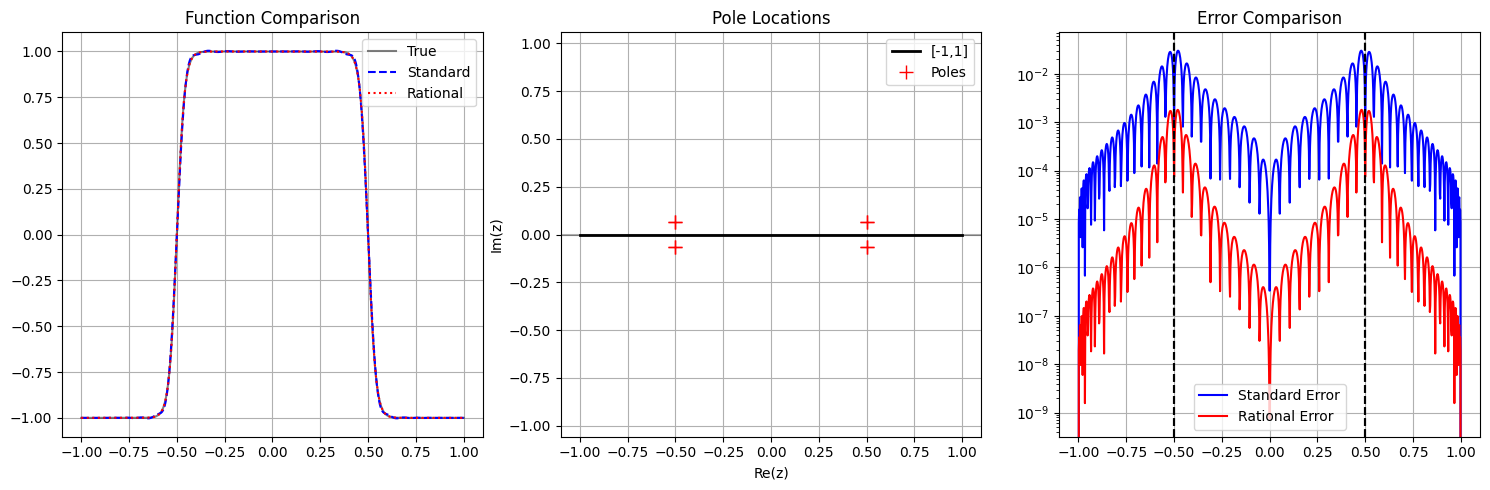

Standard max error: 2.99e-02
Rational max error: 1.79e-03


In [70]:
def plot_results(x_eval, y_true, y_standard, y_rational, rational_model):
    """Plot comparison and pole locations"""
    plt.figure(figsize=(15, 5))
    
    # Function comparison
    plt.subplot(131)
    plt.plot(x_eval, y_true, 'k-', label='True', alpha=0.5)
    plt.plot(x_eval, y_standard, 'b--', label='Standard')
    plt.plot(x_eval, y_rational, 'r:', label='Rational')
    plt.grid(True)
    plt.legend()
    plt.title('Function Comparison')
    
    # Complex plane with poles
    plt.subplot(132)
    poles = rational_model.get_poles()
    pole_real, pole_imag = poles[:, 0], poles[:, 1]
    
    # Plot real axis
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.plot([-1, 1], [0, 0], 'k-', linewidth=2, label='[-1,1]')
    
    # Plot poles
    plt.plot(pole_real, pole_imag, 'r+', markersize=10, label='Poles')
    plt.plot(pole_real, -pole_imag, 'r+', markersize=10)  # conjugates
    
    plt.grid(True)
    plt.axis('equal')  # maintain aspect ratio
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')
    plt.title('Pole Locations')
    plt.legend()
    
    # Error comparison
    plt.subplot(133)
    err_standard = torch.abs(y_standard - y_true)
    err_rational = torch.abs(y_rational - y_true)
    plt.semilogy(x_eval, err_standard, 'b-', label='Standard Error')
    plt.semilogy(x_eval, err_rational, 'r-', label='Rational Error')
    for pole_real_component in pole_real:
        plt.axvline(pole_real_component, color="black", linestyle="--")
    plt.grid(True)
    plt.legend()
    plt.title('Error Comparison')
    
    plt.tight_layout()
    plt.show()
    
    # Print max errors
    print(f"Standard max error: {err_standard.max():.2e}")
    print(f"Rational max error: {err_rational.max():.2e}")

def test_rational_interp():
    """Test rational interpolation on cos(x)"""
    # Create models
    n_points = 61
    standard_model = LagrangeInterpolationModel(n_points)
    rational_model = RationalInterpolationModel(n_points, num_poles=4)
    
    # f = lambda x : torch.cos(x * torch.pi)
    # f = lambda x : torch.abs(x)
    alpha = 50
    f = lambda x : -1.0 + 2.0 / (1.0 + torch.exp(-alpha * (0.5 - torch.abs(x))))
    
    # Evaluation points
    x_eval = torch.linspace(-1, 1, 1000)
    y_true = f(x_eval)
    
    # Set values at nodes for both models
    with torch.no_grad():
        standard_model.values.copy_(f(standard_model.nodes))
        rational_model.values.copy_(f(rational_model.nodes))
        
    # Initialize real parts
    rational_model.pole_real.data = torch.tensor([-0.5, 0.5])
    # Initialize imaginary parts
    rational_model.pole_imag.data = torch.tensor([0.065, 0.065])
    
    # Evaluate models
    y_standard = standard_model(x_eval).detach()
    y_rational = rational_model(x_eval).detach()
    
    # Plot results
    plot_results(x_eval, y_true, y_standard, y_rational, rational_model)

if __name__ == "__main__":
    test_rational_interp()

## Can we simplify the setup by directly learning the barycentric weights?

In [71]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def get_cheb_nodes(n):
    """Get Chebyshev points of the second kind"""
    i = torch.linspace(0, 1, n)
    return torch.cos(torch.pi * i)

def compute_barycentric_weights(nodes, pole_real=None, pole_imag=None):
    """
    Compute barycentric weights maintaining gradients through poles.
    
    Args:
        nodes: tensor of nodes
        pole_real: tensor of real parts of poles
        pole_imag: tensor of imaginary parts of poles (positive values, will add conjugates)
    """
    n = len(nodes)
    log_weights = torch.zeros_like(nodes)
    signs = torch.ones_like(nodes)
    
    for j in range(n):
        # Compute standard node differences
        diffs = nodes[j] - nodes
        diffs = diffs[torch.arange(n) != j]
        log_weights[j] = -torch.sum(torch.log(torch.abs(diffs)))
        signs[j] = (-1)**(torch.sum(diffs < 0))
        
        # Add pole contributions maintaining gradients
        if pole_real is not None and pole_imag is not None:
            for r, i in zip(pole_real, pole_imag):
                # Add contribution from pole and its conjugate
                pole_diff = torch.sqrt((nodes[j] - r)**2 + i**2)  # distance to p
                log_weights[j] += torch.log(pole_diff)  # p contribution
                # Conjugate is same distance so just multiply by 2
                log_weights[j] += torch.log(pole_diff)  # p̄ contribution
    
    # Convert back from log space
    log_weights = log_weights - log_weights.max()
    weights = signs * torch.exp(log_weights)
    weights = weights / torch.abs(weights[0])
    
    return weights

class RationalInterpolationModel(nn.Module):
    def __init__(self, num_points):
        """
        Rational interpolation with Chebyshev backbone and learnable weights
        
        Args:
            num_points: Number of Chebyshev points
        """
        super().__init__()
        
        # Chebyshev backbone
        self.nodes = get_cheb_nodes(num_points)
        
        # Initialize weights using standard barycentric formula
        init_weights = compute_barycentric_weights(self.nodes)
        
        # Make weights learnable parameters
        self.weights = nn.Parameter(init_weights)
        
        # Values at nodes
        self.values = nn.Parameter(torch.zeros(num_points))
        
        # Cache for differentiation matrices
        self._diff_matrices = {}
    
    def _compute_derivative_matrix(self, nodes):
        """
        Compute the spectral differentiation matrix for the given nodes
        using the learnable weights.
        """
        n = len(nodes)
        D = torch.zeros((n, n), dtype=nodes.dtype, device=nodes.device)

        # Compute off-diagonal entries using learnable weights
        for i in range(n):
            for j in range(n):
                if i != j:
                    D[i,j] = self.weights[j] / self.weights[i] / (nodes[i] - nodes[j])

        # Fill diagonal using negative sum trick
        D.diagonal().copy_(-torch.sum(D, dim=1))

        return D

    def derivative_matrix(self, k=1):
        """
        Get k-th derivative matrix (cached for efficiency)
        """
        if k == 0:
            n = len(self.nodes)
            return torch.eye(n, dtype=self.nodes.dtype, device=self.nodes.device)
            
        if k not in self._diff_matrices:
            # Compute first derivative matrix if not cached
            if 1 not in self._diff_matrices:
                self._diff_matrices[1] = self._compute_derivative_matrix(self.nodes)
            
            # Compute k-th derivative matrix by composition
            Dk = self._diff_matrices[1]
            for i in range(k-1):
                Dk = Dk @ self._diff_matrices[1]
            self._diff_matrices[k] = Dk
            
        return self._diff_matrices[k]

    def _interpolate(self, x_eval, values):
        """
        Interpolate values from nodes to x_eval using barycentric formula
        
        Args:
            x_eval: points to evaluate at (N_eval)
            values: values at self.nodes to interpolate from
        Returns:
            interpolated values at x_eval
        """
        # Compute difference matrix
        d_x = x_eval.unsqueeze(0) - self.nodes.unsqueeze(1)
        
        # Handle numerical instability
        small_diff = torch.abs(d_x) < 1e-14
        small_diff_max = torch.max(small_diff, dim=0).values
        d_x = torch.where(
            small_diff_max[None, :],
            torch.zeros_like(d_x),
            1.0 / d_x
        )
        d_x[small_diff] = 1
        
        # Compute barycentric terms using learnable weights
        f_eval_num = torch.einsum("...n,nm,n->...m", values, d_x, self.weights)
        f_eval_denom = torch.einsum("nm,n->m", d_x, self.weights)
        
        return f_eval_num / f_eval_denom

    def forward(self, x_eval):
        """Evaluate rational interpolant at x_eval points"""
        return self._interpolate(x_eval, self.values)

    def derivative(self, x_eval, k=1):
        """
        Compute k-th derivative of rational interpolant at x_eval points
        """
        if k == 0:
            return self(x_eval)
            
        # Get k-th derivative matrix
        Dk = self.derivative_matrix(k)
        
        # Compute derivative values at nodes (differentiable w.r.t self.values)
        dk_nodes = Dk @ self.values
        
        # Interpolate to evaluation points using the derivative values
        return self._interpolate(x_eval, dk_nodes)

Epoch [5000/50000], Loss: 0.000000, LR: 1.00e-02
Epoch [10000/50000], Loss: 0.000000, LR: 9.00e-03
Epoch [15000/50000], Loss: 0.000000, LR: 9.00e-03
Epoch [20000/50000], Loss: 0.000000, LR: 8.10e-03
Epoch [25000/50000], Loss: 0.000000, LR: 8.10e-03
Epoch [30000/50000], Loss: 0.000000, LR: 7.29e-03
Epoch [35000/50000], Loss: 0.000000, LR: 7.29e-03
Epoch [40000/50000], Loss: 0.000000, LR: 6.56e-03
Epoch [45000/50000], Loss: 0.000000, LR: 6.56e-03
Epoch [50000/50000], Loss: 0.000000, LR: 5.90e-03


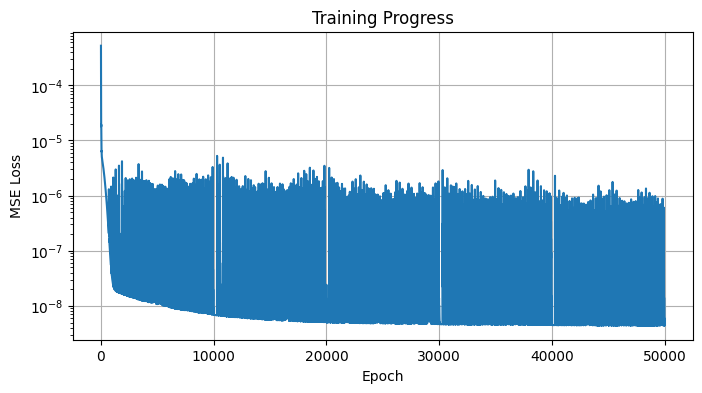

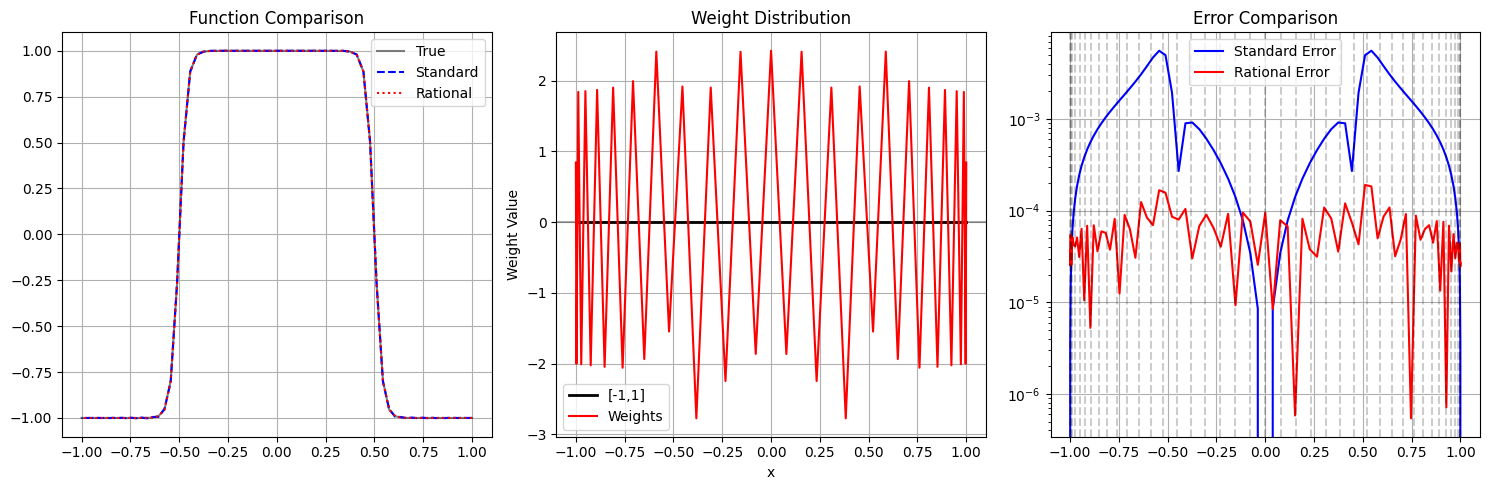

Standard max error: 5.57e-03
Rational max error: 1.91e-04


In [99]:
import torch
import matplotlib.pyplot as plt

def plot_results(x_eval, y_true, y_standard, y_rational, rational_model):
    """Plot comparison and weight distributions"""
    plt.figure(figsize=(15, 5))
    
    # Function comparison
    plt.subplot(131)
    plt.plot(x_eval, y_true, 'k-', label='True', alpha=0.5)
    plt.plot(x_eval, y_standard, 'b--', label='Standard')
    plt.plot(x_eval, y_rational, 'r:', label='Rational')
    plt.grid(True)
    plt.legend()
    plt.title('Function Comparison')
    
    # Weight distribution
    plt.subplot(132)
    weights = rational_model.weights.detach()
    nodes = rational_model.nodes.detach()
    
    # Plot real axis
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.plot([-1, 1], [0, 0], 'k-', linewidth=2, label='[-1,1]')
    
    # Plot weights as stems
    plt.plot(nodes, weights, 'r-', label='Weights')
    
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('Weight Value')
    plt.title('Weight Distribution')
    plt.legend()
    
    # Error comparison
    plt.subplot(133)
    err_standard = torch.abs(y_standard - y_true)
    err_rational = torch.abs(y_rational - y_true)
    plt.semilogy(x_eval, err_standard, 'b-', label='Standard Error')
    plt.semilogy(x_eval, err_rational, 'r-', label='Rational Error')
    
    # Plot vertical lines at nodes
    for node in nodes:
        plt.axvline(node.item(), color="black", linestyle="--", alpha=0.2)
    
    plt.grid(True)
    plt.legend()
    plt.title('Error Comparison')
    
    plt.tight_layout()
    plt.show()
    
    # Print max errors
    print(f"Standard max error: {err_standard.max():.2e}")
    print(f"Rational max error: {err_rational.max():.2e}")

def train_rational_interp(n_epochs=1000, lr=0.01):
    """Train rational interpolation on cos(x)"""
    # Create models
    n_points = 41
    oversample = 40
    standard_model = LagrangeInterpolationModel(n_points+oversample)
    rational_model = RationalInterpolationModel(n_points)
    
    # f = lambda x : torch.cos(x * torch.pi)
    # f = lambda x : torch.abs(x)
    alpha = 50
    f = lambda x : -1.0 + 2.0 / (1.0 + torch.exp(-alpha * (0.5 - torch.abs(x))))
    
    # Training points (use more points than nodes for better generalization)
    x_train = get_cheb_nodes(n_points+oversample)
    y_train = f(x_train)
    
    # Evaluation points (denser grid for visualization)
    x_eval = get_cheb_nodes(2*n_points+1)
    y_true = f(x_eval)
    
    # Set values at nodes for both models
    with torch.no_grad():
        standard_model.values.copy_(f(standard_model.nodes))
        rational_model.values.copy_(f(rational_model.nodes))
    
    # Setup optimizer
    optimizer = torch.optim.Adam(rational_model.parameters(), lr=lr)
    
    # Setup scheduler - reduce LR by factor of 0.1 every 2000 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
    
    # Training loop
    losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = rational_model(x_train)
        
        # Compute loss
        loss = torch.mean((y_pred - y_train) ** 2)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Step the scheduler
        scheduler.step()
        
        # Record loss
        losses.append(loss.item())
        
        # Print progress
        if (epoch + 1) % (n_epochs // 10) == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}, LR: {scheduler.get_last_lr()[0]:.2e}')
    
    # Plot training curve
    plt.figure(figsize=(8, 4))
    plt.semilogy(losses)
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Progress')
    plt.show()
    
    # Evaluate models
    with torch.no_grad():
        y_standard = standard_model(x_eval)
        y_rational = rational_model(x_eval)
    
    # Plot final results
    plot_results(x_eval, y_true, y_standard, y_rational, rational_model)

if __name__ == "__main__":
    train_rational_interp(n_epochs=50000, lr=0.01)

## How well does the rational approximate the derivative?

Epoch [5000/50000], Loss: 0.000000, LR: 1.00e-02
Epoch [10000/50000], Loss: 0.000000, LR: 9.00e-03
Epoch [15000/50000], Loss: 0.000000, LR: 9.00e-03
Epoch [20000/50000], Loss: 0.000000, LR: 8.10e-03
Epoch [25000/50000], Loss: 0.000000, LR: 8.10e-03
Epoch [30000/50000], Loss: 0.000000, LR: 7.29e-03
Epoch [35000/50000], Loss: 0.000000, LR: 7.29e-03
Epoch [40000/50000], Loss: 0.000000, LR: 6.56e-03
Epoch [45000/50000], Loss: 0.000000, LR: 6.56e-03
Epoch [50000/50000], Loss: 0.000000, LR: 5.90e-03


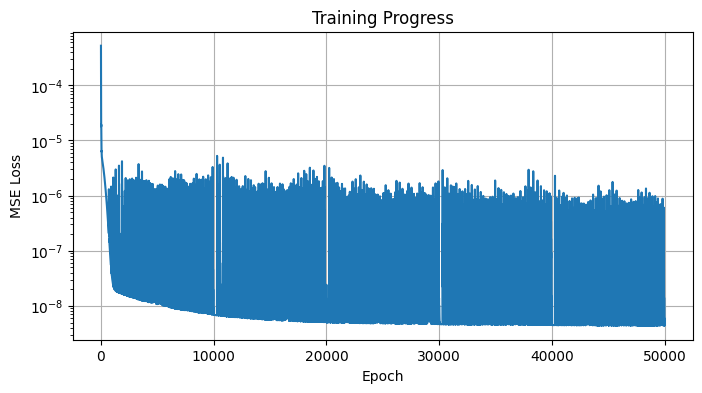

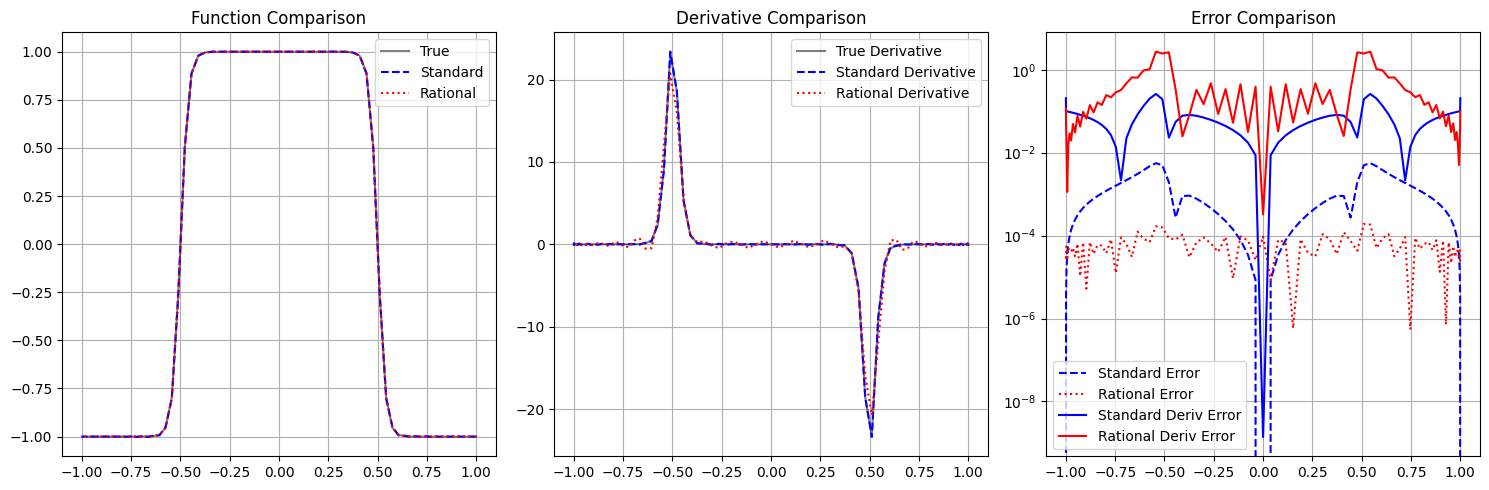

Standard max error: 5.57e-03
Rational max error: 1.91e-04
Standard derivative max error: 2.60e-01
Rational derivative max error: 2.73e+00


In [97]:
import torch
import matplotlib.pyplot as plt

def plot_derivative_results(x_eval, y_true, y_standard, y_rational, y_true_deriv, y_standard_deriv, y_rational_deriv):
    """Plot function and derivative comparison"""
    plt.figure(figsize=(15, 5))
    
    # Function comparison
    plt.subplot(131)
    plt.plot(x_eval, y_true, 'k-', label='True', alpha=0.5)
    plt.plot(x_eval, y_standard, 'b--', label='Standard')
    plt.plot(x_eval, y_rational, 'r:', label='Rational')
    plt.grid(True)
    plt.legend()
    plt.title('Function Comparison')
    
    # Derivative comparison
    plt.subplot(132)
    plt.plot(x_eval, y_true_deriv, 'k-', label='True Derivative', alpha=0.5)
    plt.plot(x_eval, y_standard_deriv, 'b--', label='Standard Derivative')
    plt.plot(x_eval, y_rational_deriv, 'r:', label='Rational Derivative')
    plt.grid(True)
    plt.legend()
    plt.title('Derivative Comparison')
    
    # Error comparison
    plt.subplot(133)
    err_standard = torch.abs(y_standard - y_true)
    err_rational = torch.abs(y_rational - y_true)
    err_standard_deriv = torch.abs(y_standard_deriv - y_true_deriv)
    err_rational_deriv = torch.abs(y_rational_deriv - y_true_deriv)
    
    plt.semilogy(x_eval, err_standard, 'b--', label='Standard Error')
    plt.semilogy(x_eval, err_rational, 'r:', label='Rational Error')
    plt.semilogy(x_eval, err_standard_deriv, 'b-', label='Standard Deriv Error')
    plt.semilogy(x_eval, err_rational_deriv, 'r-', label='Rational Deriv Error')
    
    plt.grid(True)
    plt.legend()
    plt.title('Error Comparison')
    
    plt.tight_layout()
    plt.show()
    
    # Print max errors
    print(f"Standard max error: {err_standard.max():.2e}")
    print(f"Rational max error: {err_rational.max():.2e}")
    print(f"Standard derivative max error: {err_standard_deriv.max():.2e}")
    print(f"Rational derivative max error: {err_rational_deriv.max():.2e}")

def train_with_derivative(n_epochs=50000, lr=0.01):
    """Train rational interpolation and test derivative approximation"""
    # Create models
    n_points = 41
    oversample = 40
    standard_model = LagrangeInterpolationModel(n_points+oversample)
    rational_model = RationalInterpolationModel(n_points)
    
    # Define function and its analytical derivative
    alpha = 50
    f = lambda x : -1.0 + 2.0 / (1.0 + torch.exp(-alpha * (0.5 - torch.abs(x))))
    
    def df(x):
        abs_x = torch.abs(x)
        d_abs_x = torch.sign(x)
        exp_term = torch.exp(-alpha * (0.5 - abs_x))
        return -2 * alpha * d_abs_x * exp_term / (1 + exp_term)**2
    
    # Training points
    x_train = get_cheb_nodes(n_points+oversample)
    y_train = f(x_train)
    
    # Evaluation points
    x_eval = get_cheb_nodes(2*n_points+1)
    y_true = f(x_eval)
    y_true_deriv = df(x_eval)
    
    # Set initial values at nodes
    with torch.no_grad():
        standard_model.values.copy_(f(standard_model.nodes))
        rational_model.values.copy_(f(rational_model.nodes))
    
    # Setup optimizer and scheduler
    optimizer = torch.optim.Adam(rational_model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
    
    # Training loop
    losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        y_pred = rational_model(x_train)
        loss = torch.mean((y_pred - y_train) ** 2)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        
        if (epoch + 1) % (n_epochs // 10) == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}, LR: {scheduler.get_last_lr()[0]:.2e}')
    
    # Plot training curve
    plt.figure(figsize=(8, 4))
    plt.semilogy(losses)
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Progress')
    plt.show()
    
    # Evaluate function and derivative
    with torch.no_grad():
        y_standard = standard_model(x_eval)
        y_rational = rational_model(x_eval)
        y_standard_deriv = standard_model.derivative(x_eval, k=1)
        y_rational_deriv = rational_model.derivative(x_eval, k=1)
    
    # Plot results
    plot_derivative_results(x_eval, y_true, y_standard, y_rational, 
                          y_true_deriv, y_standard_deriv, y_rational_deriv)

if __name__ == "__main__":
    train_with_derivative()

## Steep transition

  3%|▎         | 102/4000 [00:07<04:50, 13.43it/s]

Epoch 100/4000
Standard - MSE: 0.001829, L∞: 0.166831
Rational - MSE: 0.112255, L∞: 1.003212


  5%|▌         | 202/4000 [00:15<04:42, 13.43it/s]

Epoch 200/4000
Standard - MSE: 0.001513, L∞: 0.106903
Rational - MSE: 0.100821, L∞: 0.985640


  8%|▊         | 302/4000 [00:22<04:34, 13.48it/s]

Epoch 300/4000
Standard - MSE: 0.001512, L∞: 0.105477
Rational - MSE: 0.086710, L∞: 0.937326


 10%|█         | 402/4000 [00:30<04:32, 13.22it/s]

Epoch 400/4000
Standard - MSE: 0.001502, L∞: 0.106733
Rational - MSE: 0.065794, L∞: 0.840597


 13%|█▎        | 502/4000 [00:37<04:22, 13.32it/s]

Epoch 500/4000
Standard - MSE: 0.001518, L∞: 0.106898
Rational - MSE: 0.027808, L∞: 0.758124


 15%|█▌        | 602/4000 [00:45<04:08, 13.65it/s]

Epoch 600/4000
Standard - MSE: 0.001518, L∞: 0.107203
Rational - MSE: 0.012917, L∞: 0.594464


 18%|█▊        | 702/4000 [00:52<04:02, 13.62it/s]

Epoch 700/4000
Standard - MSE: 0.001522, L∞: 0.107306
Rational - MSE: 0.003911, L∞: 0.356157


 20%|██        | 802/4000 [01:00<04:02, 13.19it/s]

Epoch 800/4000
Standard - MSE: 0.001514, L∞: 0.106839
Rational - MSE: 0.000633, L∞: 0.125753


 23%|██▎       | 902/4000 [01:07<03:52, 13.31it/s]

Epoch 900/4000
Standard - MSE: 0.001510, L∞: 0.105933
Rational - MSE: 0.000355, L∞: 0.060763


 25%|██▌       | 1002/4000 [01:14<03:32, 14.10it/s]

Epoch 1000/4000
Standard - MSE: 0.001523, L∞: 0.107017
Rational - MSE: 0.000310, L∞: 0.058211


 28%|██▊       | 1102/4000 [01:22<03:27, 13.95it/s]

Epoch 1100/4000
Standard - MSE: 0.001508, L∞: 0.106416
Rational - MSE: 0.000263, L∞: 0.053890


 30%|███       | 1202/4000 [01:29<03:28, 13.45it/s]

Epoch 1200/4000
Standard - MSE: 0.001514, L∞: 0.106920
Rational - MSE: 0.000228, L∞: 0.051646


 33%|███▎      | 1302/4000 [01:37<03:34, 12.57it/s]

Epoch 1300/4000
Standard - MSE: 0.001513, L∞: 0.106543
Rational - MSE: 0.000198, L∞: 0.048895


 35%|███▌      | 1402/4000 [01:44<03:19, 13.02it/s]

Epoch 1400/4000
Standard - MSE: 0.001516, L∞: 0.108089
Rational - MSE: 0.000179, L∞: 0.047122


 38%|███▊      | 1502/4000 [01:51<02:59, 13.88it/s]

Epoch 1500/4000
Standard - MSE: 0.001523, L∞: 0.106940
Rational - MSE: 0.000162, L∞: 0.045303


 40%|████      | 1602/4000 [01:59<03:05, 12.90it/s]

Epoch 1600/4000
Standard - MSE: 0.001519, L∞: 0.107064
Rational - MSE: 0.000144, L∞: 0.043022


 43%|████▎     | 1702/4000 [02:06<02:52, 13.33it/s]

Epoch 1700/4000
Standard - MSE: 0.001516, L∞: 0.106471
Rational - MSE: 0.000135, L∞: 0.042195


 45%|████▌     | 1802/4000 [02:13<02:44, 13.37it/s]

Epoch 1800/4000
Standard - MSE: 0.001509, L∞: 0.106273
Rational - MSE: 0.000123, L∞: 0.041442


 48%|████▊     | 1902/4000 [02:21<02:16, 15.37it/s]

Epoch 1900/4000
Standard - MSE: 0.001516, L∞: 0.105721
Rational - MSE: 0.000117, L∞: 0.040601


 50%|█████     | 2002/4000 [02:28<02:27, 13.50it/s]

Epoch 2000/4000
Standard - MSE: 0.001523, L∞: 0.106676
Rational - MSE: 0.000113, L∞: 0.039736


 53%|█████▎    | 2102/4000 [02:35<02:26, 12.93it/s]

Epoch 2100/4000
Standard - MSE: 0.001524, L∞: 0.107611
Rational - MSE: 0.000113, L∞: 0.039790


 55%|█████▌    | 2202/4000 [02:43<02:15, 13.27it/s]

Epoch 2200/4000
Standard - MSE: 0.001510, L∞: 0.105453
Rational - MSE: 0.000107, L∞: 0.039078


 58%|█████▊    | 2302/4000 [02:50<01:53, 14.91it/s]

Epoch 2300/4000
Standard - MSE: 0.001524, L∞: 0.107272
Rational - MSE: 0.000109, L∞: 0.039059


 60%|██████    | 2402/4000 [02:58<01:59, 13.41it/s]

Epoch 2400/4000
Standard - MSE: 0.001516, L∞: 0.107488
Rational - MSE: 0.000103, L∞: 0.038631


 63%|██████▎   | 2502/4000 [03:05<01:52, 13.31it/s]

Epoch 2500/4000
Standard - MSE: 0.001516, L∞: 0.108273
Rational - MSE: 0.000103, L∞: 0.038922


 65%|██████▌   | 2602/4000 [03:13<01:46, 13.07it/s]

Epoch 2600/4000
Standard - MSE: 0.001514, L∞: 0.106538
Rational - MSE: 0.000101, L∞: 0.038386


 68%|██████▊   | 2702/4000 [03:20<01:33, 13.92it/s]

Epoch 2700/4000
Standard - MSE: 0.001512, L∞: 0.107717
Rational - MSE: 0.000099, L∞: 0.039133


 70%|███████   | 2802/4000 [03:27<01:34, 12.69it/s]

Epoch 2800/4000
Standard - MSE: 0.001512, L∞: 0.106397
Rational - MSE: 0.000099, L∞: 0.038600


 73%|███████▎  | 2902/4000 [03:35<01:26, 12.68it/s]

Epoch 2900/4000
Standard - MSE: 0.001522, L∞: 0.108214
Rational - MSE: 0.000098, L∞: 0.038341


 75%|███████▌  | 3003/4000 [03:43<01:00, 16.45it/s]

Epoch 3000/4000
Standard - MSE: 0.001512, L∞: 0.107202
Rational - MSE: 0.000098, L∞: 0.039139


 78%|███████▊  | 3102/4000 [03:47<00:41, 21.84it/s]

Epoch 3100/4000
Standard - MSE: 0.001515, L∞: 0.106992
Rational - MSE: 0.000098, L∞: 0.038212


 80%|████████  | 3204/4000 [03:52<00:36, 21.89it/s]

Epoch 3200/4000
Standard - MSE: 0.001525, L∞: 0.108059
Rational - MSE: 0.000099, L∞: 0.039004


 83%|████████▎ | 3303/4000 [03:56<00:31, 21.93it/s]

Epoch 3300/4000
Standard - MSE: 0.001512, L∞: 0.107469
Rational - MSE: 0.000097, L∞: 0.038050


 85%|████████▌ | 3402/4000 [04:01<00:25, 23.42it/s]

Epoch 3400/4000
Standard - MSE: 0.001518, L∞: 0.107414
Rational - MSE: 0.000097, L∞: 0.038229


 88%|████████▊ | 3504/4000 [04:05<00:22, 22.09it/s]

Epoch 3500/4000
Standard - MSE: 0.001516, L∞: 0.105992
Rational - MSE: 0.000097, L∞: 0.038217


 90%|█████████ | 3603/4000 [04:10<00:18, 21.87it/s]

Epoch 3600/4000
Standard - MSE: 0.001522, L∞: 0.107830
Rational - MSE: 0.000098, L∞: 0.038072


 93%|█████████▎| 3702/4000 [04:14<00:13, 21.86it/s]

Epoch 3700/4000
Standard - MSE: 0.001515, L∞: 0.107024
Rational - MSE: 0.000098, L∞: 0.037987


 95%|█████████▌| 3804/4000 [04:19<00:08, 22.04it/s]

Epoch 3800/4000
Standard - MSE: 0.001519, L∞: 0.106017
Rational - MSE: 0.000098, L∞: 0.038017


 98%|█████████▊| 3903/4000 [04:23<00:04, 22.18it/s]

Epoch 3900/4000
Standard - MSE: 0.001513, L∞: 0.106206
Rational - MSE: 0.000101, L∞: 0.038793


100%|██████████| 4000/4000 [04:28<00:00, 14.89it/s]


Epoch 4000/4000
Standard - MSE: 0.001520, L∞: 0.106929
Rational - MSE: 0.000098, L∞: 0.038045


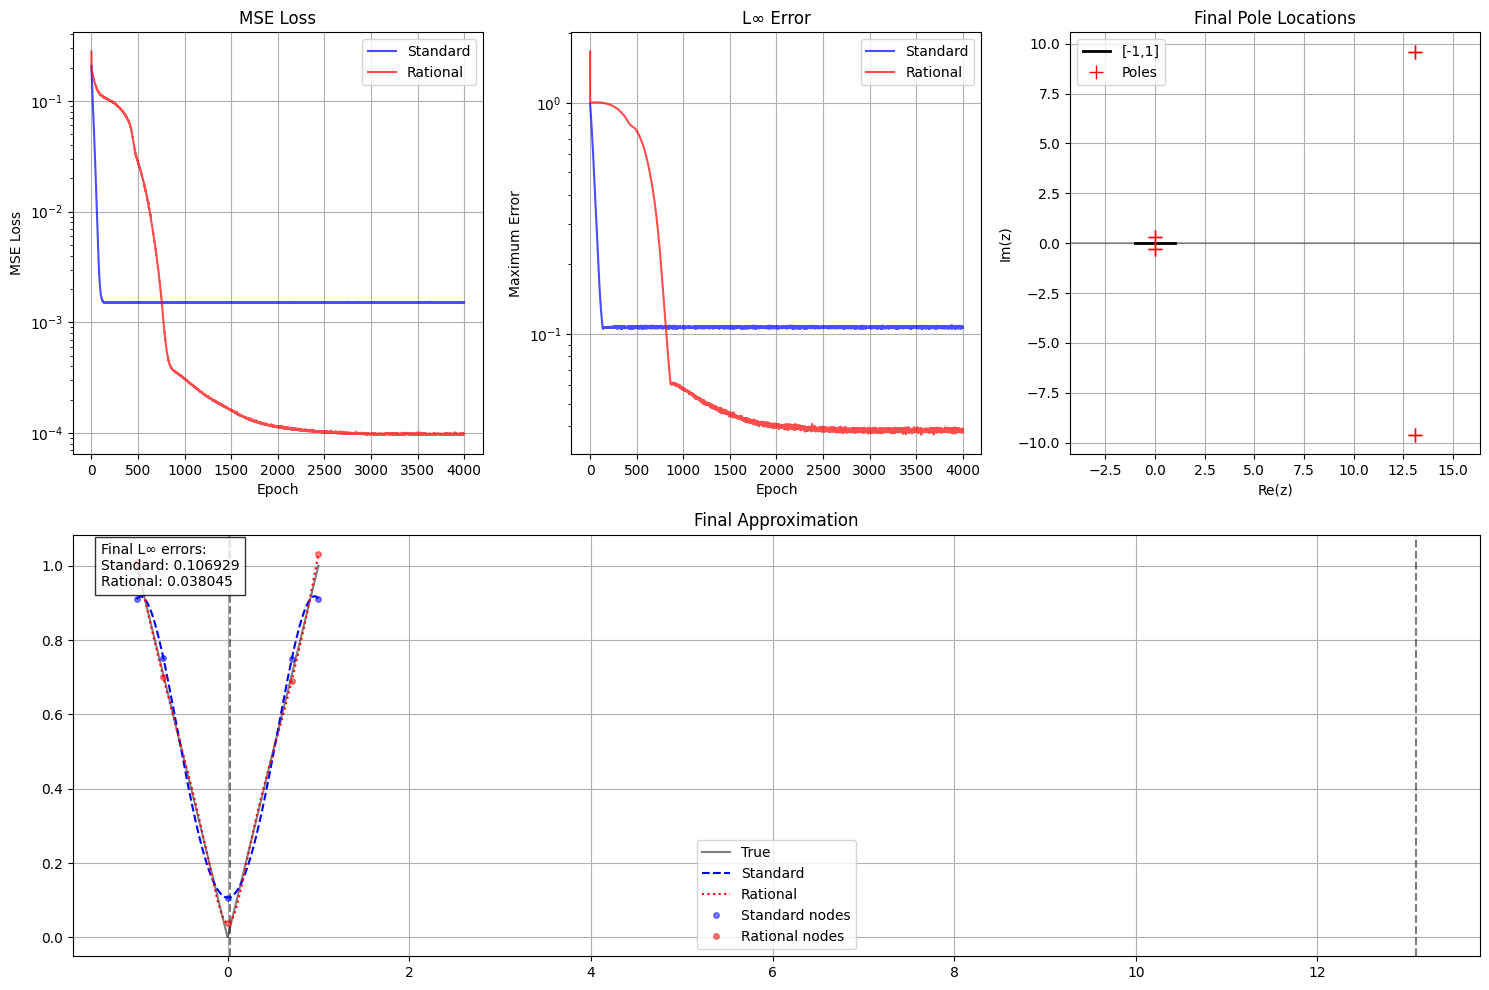

In [29]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

def steep_transition(x, alpha=50.0):
    """Logistic transition function"""
    return torch.abs(x)

def compute_linf_error(model, x_eval, y_true):
    """Compute L-infinity error for model"""
    with torch.no_grad():
        y_pred = model(x_eval)
        error = torch.max(torch.abs(y_pred - y_true)).item()
    return error

def train_interpolation(standard_model, rational_model, num_epochs=1000, batch_size=128, freeze_poles=500):
    """Train both models on the steep transition function"""
    # Generate training data with more points near transition
    x_uniform = torch.linspace(-1, 1, 1000)
    x_dense = torch.linspace(-0.6, 0.4, 1000)  # More points near transition
    x_train = torch.cat([x_uniform, x_dense])
    y_train = steep_transition(x_train)
    
    # Create data loader
    dataset = TensorDataset(x_train, y_train)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Optimizers
    opt_standard = optim.Adam(standard_model.parameters(), lr=1e-3)
    opt_rational = optim.Adam(rational_model.parameters(), lr=1e-3)
    
    # Training history
    standard_losses = []
    rational_losses = []
    standard_linf = []
    rational_linf = []
    
    for epoch in tqdm(range(num_epochs)):
        standard_epoch_loss = 0.0
        rational_epoch_loss = 0.0
        
        if epoch == freeze_poles:
            rational_model.pole_real.requires_grad = False
            rational_model.pole_imag.requires_grad = False
        
        for x_batch, y_batch in loader:
            # Train standard model
            opt_standard.zero_grad()
            y_pred_standard = standard_model(x_batch)
            loss_standard = torch.nn.functional.mse_loss(y_pred_standard, y_batch)
            loss_standard.backward()
            opt_standard.step()
            
            # Train rational model
            opt_rational.zero_grad()
            y_pred_rational = rational_model(x_batch)
            loss_rational = torch.nn.functional.mse_loss(y_pred_rational, y_batch)
            loss_rational.backward()
            opt_rational.step()
            
            standard_epoch_loss += loss_standard.item()
            rational_epoch_loss += loss_rational.item()
        
        # Record average epoch losses
        standard_losses.append(standard_epoch_loss / len(loader))
        rational_losses.append(rational_epoch_loss / len(loader))
        
        # Compute L-infinity errors
        standard_linf.append(compute_linf_error(standard_model, x_train, y_train))
        rational_linf.append(compute_linf_error(rational_model, x_train, y_train))
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Standard - MSE: {standard_losses[-1]:.6f}, L∞: {standard_linf[-1]:.6f}")
            print(f"Rational - MSE: {rational_losses[-1]:.6f}, L∞: {rational_linf[-1]:.6f}")
    
    return (standard_losses, rational_losses), (standard_linf, rational_linf)

def plot_training_results(x_eval, standard_model, rational_model, losses):
    """Plot training results and final approximation"""
    (standard_losses, rational_losses), (standard_linf, rational_linf) = losses
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot MSE losses
    plt.subplot(231)
    plt.semilogy(standard_losses, 'b-', label='Standard', alpha=0.7)
    plt.semilogy(rational_losses, 'r-', label='Rational', alpha=0.7)
    plt.grid(True)
    plt.legend()
    plt.title('MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    
    # Plot L-infinity errors
    plt.subplot(232)
    plt.semilogy(standard_linf, 'b-', label='Standard', alpha=0.7)
    plt.semilogy(rational_linf, 'r-', label='Rational', alpha=0.7)
    plt.grid(True)
    plt.legend()
    plt.title('L∞ Error')
    plt.xlabel('Epoch')
    plt.ylabel('Maximum Error')
    
    # Plot pole locations
    plt.subplot(233)
    poles = rational_model.get_poles()
    pole_real, pole_imag = poles[:, 0], poles[:, 1]
    
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.plot([-1, 1], [0, 0], 'k-', linewidth=2, label='[-1,1]')
    plt.plot(pole_real, pole_imag, 'r+', markersize=10, label='Poles')
    plt.plot(pole_real, -pole_imag, 'r+', markersize=10)
    
    plt.grid(True)
    plt.axis('equal')
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')
    plt.title('Final Pole Locations')
    plt.legend()
    
    # Plot function comparison
    plt.subplot(212)
    y_true = steep_transition(x_eval)
    with torch.no_grad():
        y_standard = standard_model(x_eval)
        y_rational = rational_model(x_eval)
    
    plt.plot(x_eval, y_true, 'k-', label='True', alpha=0.5)
    plt.plot(x_eval, y_standard, 'b--', label='Standard')
    plt.plot(x_eval, y_rational, 'r:', label='Rational')
    
    # Plot poles as vertical lines
    for pole_real_component in pole_real:
        plt.axvline(pole_real_component, color="black", linestyle="--", alpha=0.3)
    
    # Plot nodes
    plt.plot(standard_model.nodes, standard_model.values.detach(), 
             'b.', alpha=0.5, markersize=8, label='Standard nodes')
    plt.plot(rational_model.nodes, rational_model.values.detach(), 
             'r.', alpha=0.5, markersize=8, label='Rational nodes')
    
    # Print final errors
    final_standard_linf = standard_linf[-1]
    final_rational_linf = rational_linf[-1]
    plt.text(0.02, 0.98, f'Final L∞ errors:\nStandard: {final_standard_linf:.6f}\nRational: {final_rational_linf:.6f}',
             transform=plt.gca().transAxes, verticalalignment='top', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.grid(True)
    plt.legend()
    plt.title('Final Approximation')
    
    plt.tight_layout()
    plt.show()

# Create models
n_points = 5
standard_model = LagrangeInterpolationModel(n_points)
rational_model = RationalInterpolationModel(n_points, num_poles=4)

# Train models
losses = train_interpolation(standard_model, rational_model, num_epochs=4000, freeze_poles=3000)

# Evaluate and plot results
x_eval = torch.linspace(-1, 1, 1000)
plot_training_results(x_eval, standard_model, rational_model, losses)

  3%|▎         | 101/3000 [00:07<03:35, 13.44it/s]

Epoch 100/3000
Standard - MSE: 0.001867, L∞: 0.173315
Rational - MSE: 0.076553, L∞: 0.904706


  7%|▋         | 201/3000 [00:15<03:30, 13.30it/s]

Epoch 200/3000
Standard - MSE: 0.001518, L∞: 0.106999
Rational - MSE: 0.020053, L∞: 0.659499


 10%|█         | 301/3000 [00:23<03:20, 13.43it/s]

Epoch 300/3000
Standard - MSE: 0.001505, L∞: 0.107496
Rational - MSE: 0.004585, L∞: 0.416150


 13%|█▎        | 401/3000 [00:30<03:01, 14.31it/s]

Epoch 400/3000
Standard - MSE: 0.001515, L∞: 0.107414
Rational - MSE: 0.002157, L∞: 0.230917


 17%|█▋        | 501/3000 [00:37<03:06, 13.43it/s]

Epoch 500/3000
Standard - MSE: 0.001521, L∞: 0.107507
Rational - MSE: 0.001310, L∞: 0.101717


 20%|██        | 601/3000 [00:45<03:00, 13.31it/s]

Epoch 600/3000
Standard - MSE: 0.001523, L∞: 0.107232
Rational - MSE: 0.000298, L∞: 0.059072


 23%|██▎       | 701/3000 [00:52<02:53, 13.27it/s]

Epoch 700/3000
Standard - MSE: 0.001528, L∞: 0.107885
Rational - MSE: 0.000036, L∞: 0.027914


 27%|██▋       | 801/3000 [01:00<02:38, 13.83it/s]

Epoch 800/3000
Standard - MSE: 0.001518, L∞: 0.107130
Rational - MSE: 0.000018, L∞: 0.021313


 30%|███       | 901/3000 [01:07<02:52, 12.13it/s]

Epoch 900/3000
Standard - MSE: 0.001512, L∞: 0.107116
Rational - MSE: 0.000017, L∞: 0.021323


 33%|███▎      | 1001/3000 [01:15<02:29, 13.33it/s]

Epoch 1000/3000
Standard - MSE: 0.001514, L∞: 0.107235
Rational - MSE: 0.000017, L∞: 0.020215


 37%|███▋      | 1101/3000 [01:22<02:19, 13.65it/s]

Epoch 1100/3000
Standard - MSE: 0.001508, L∞: 0.106431
Rational - MSE: 0.000017, L∞: 0.020584


 40%|████      | 1201/3000 [01:30<02:15, 13.28it/s]

Epoch 1200/3000
Standard - MSE: 0.001524, L∞: 0.107853
Rational - MSE: 0.000017, L∞: 0.020780


 43%|████▎     | 1301/3000 [01:38<02:10, 13.00it/s]

Epoch 1300/3000
Standard - MSE: 0.001513, L∞: 0.105869
Rational - MSE: 0.000017, L∞: 0.020527


 47%|████▋     | 1401/3000 [01:45<01:55, 13.85it/s]

Epoch 1400/3000
Standard - MSE: 0.001511, L∞: 0.108367
Rational - MSE: 0.000017, L∞: 0.020481


 50%|█████     | 1501/3000 [01:52<01:54, 13.15it/s]

Epoch 1500/3000
Standard - MSE: 0.001516, L∞: 0.106914
Rational - MSE: 0.000017, L∞: 0.020860


 53%|█████▎    | 1601/3000 [02:00<01:45, 13.29it/s]

Epoch 1600/3000
Standard - MSE: 0.001517, L∞: 0.107425
Rational - MSE: 0.000018, L∞: 0.020437


 57%|█████▋    | 1703/3000 [02:07<01:29, 14.55it/s]

Epoch 1700/3000
Standard - MSE: 0.001517, L∞: 0.107070
Rational - MSE: 0.000017, L∞: 0.021123


 60%|██████    | 1801/3000 [02:15<01:26, 13.89it/s]

Epoch 1800/3000
Standard - MSE: 0.001517, L∞: 0.108357
Rational - MSE: 0.000017, L∞: 0.021167


 63%|██████▎   | 1901/3000 [02:22<01:24, 13.02it/s]

Epoch 1900/3000
Standard - MSE: 0.001520, L∞: 0.107343
Rational - MSE: 0.000018, L∞: 0.020661


 67%|██████▋   | 2001/3000 [02:29<01:15, 13.21it/s]

Epoch 2000/3000
Standard - MSE: 0.001513, L∞: 0.107976
Rational - MSE: 0.000017, L∞: 0.020413


 70%|███████   | 2101/3000 [02:37<01:02, 14.48it/s]

Epoch 2100/3000
Standard - MSE: 0.001512, L∞: 0.106334
Rational - MSE: 0.000018, L∞: 0.021458


 73%|███████▎  | 2201/3000 [02:44<00:59, 13.46it/s]

Epoch 2200/3000
Standard - MSE: 0.001516, L∞: 0.106854
Rational - MSE: 0.000017, L∞: 0.020611


 77%|███████▋  | 2301/3000 [02:52<00:52, 13.19it/s]

Epoch 2300/3000
Standard - MSE: 0.001522, L∞: 0.107485
Rational - MSE: 0.000017, L∞: 0.020237


 80%|████████  | 2401/3000 [02:59<00:45, 13.20it/s]

Epoch 2400/3000
Standard - MSE: 0.001517, L∞: 0.107613
Rational - MSE: 0.000018, L∞: 0.020752


 83%|████████▎ | 2503/3000 [03:07<00:33, 14.86it/s]

Epoch 2500/3000
Standard - MSE: 0.001515, L∞: 0.106761
Rational - MSE: 0.000017, L∞: 0.020181


 87%|████████▋ | 2601/3000 [03:14<00:30, 13.29it/s]

Epoch 2600/3000
Standard - MSE: 0.001517, L∞: 0.107254
Rational - MSE: 0.000017, L∞: 0.020624


 90%|█████████ | 2701/3000 [03:21<00:22, 13.22it/s]

Epoch 2700/3000
Standard - MSE: 0.001522, L∞: 0.107780
Rational - MSE: 0.000017, L∞: 0.020965


 93%|█████████▎| 2801/3000 [03:29<00:15, 13.22it/s]

Epoch 2800/3000
Standard - MSE: 0.001520, L∞: 0.107693
Rational - MSE: 0.000017, L∞: 0.020671


 97%|█████████▋| 2901/3000 [03:36<00:06, 14.86it/s]

Epoch 2900/3000
Standard - MSE: 0.001519, L∞: 0.107436
Rational - MSE: 0.000018, L∞: 0.020620


100%|██████████| 3000/3000 [03:43<00:00, 13.41it/s]


Epoch 3000/3000
Standard - MSE: 0.001518, L∞: 0.108076
Rational - MSE: 0.000018, L∞: 0.020874


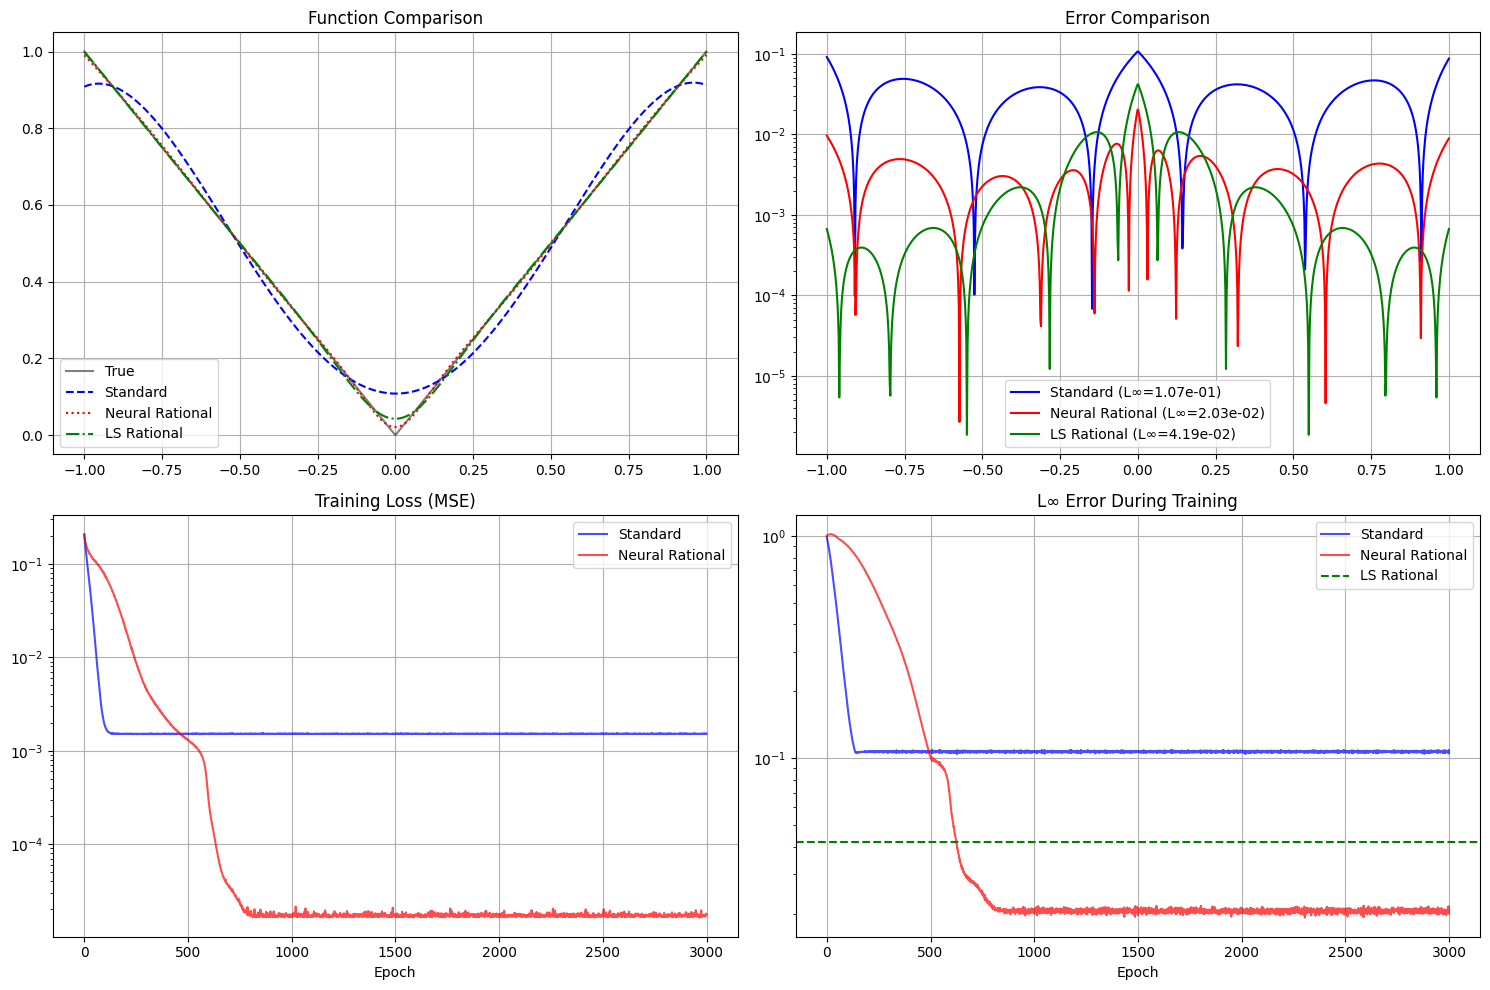


Final L∞ errors:
Standard:       1.07e-01
Neural Rational:2.03e-02
LS Rational:    4.19e-02


In [31]:
import torch
import torch.optim as optim
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

@dataclass
class RationalCoeffs:
    """Rational function in coefficient form"""
    num_coeffs: np.ndarray  # coefficients of numerator
    den_coeffs: np.ndarray  # coefficients of denominator

def fit_rational_ls(func, degree, domain=(-1, 1), num_samples=2000):
    """Fit rational function using least squares on coefficients"""
    # Sample the function
    x_samp = np.linspace(domain[0], domain[1], num_samples)
    f_samp = func(x_samp)
    
    # Build design matrices for least squares
    Xpow = np.column_stack([x_samp**k for k in range(degree+1)])
    Xpow_d = np.column_stack([x_samp**k for k in range(1, degree+1)])
    A_right = -(f_samp.reshape(-1,1)) * Xpow_d
    A = np.hstack([Xpow, A_right])
    b = f_samp.copy()
    
    # Solve least squares
    sol, residuals, rank, svals = np.linalg.lstsq(A, b, rcond=None)
    
    # Extract coefficients
    c_coeffs = sol[0 : (degree+1)]
    d_coeffs = np.concatenate(([1.0], sol[degree+1 : (2*degree+1)]))
    
    return RationalCoeffs(c_coeffs, d_coeffs)

def evaluate_rational(x, coeffs):
    """Evaluate rational function in coefficient form"""
    degree = len(coeffs.num_coeffs) - 1
    x = np.asarray(x)
    
    xpow = np.column_stack([x**k for k in range(degree+1)])
    num = xpow.dot(coeffs.num_coeffs)
    den = xpow.dot(coeffs.den_coeffs)
    
    return num / den

def train_and_compare(standard_model, rational_model, n_points, degree=4):
    """Train and compare all methods"""
    # Generate evaluation points
    x_eval = torch.linspace(-1, 1, 1000)
    y_true = steep_transition(x_eval)
    
    # Train neural models
    losses = train_interpolation(standard_model, rational_model, num_epochs=3000, freeze_poles=4000)
    
    # Fit least squares rational
    def f_numpy(x):
        return np.abs(x)  # Same as steep_transition but for numpy
    
    ls_rational = fit_rational_ls(f_numpy, degree=degree)
    
    # Evaluate all models
    with torch.no_grad():
        y_standard = standard_model(x_eval)
        y_rational = rational_model(x_eval)
    
    y_ls_rational = evaluate_rational(x_eval.numpy(), ls_rational)
    
    # Compute L-infinity errors
    err_standard = torch.max(torch.abs(y_standard - y_true)).item()
    err_rational = torch.max(torch.abs(y_rational - y_true)).item()
    err_ls_rational = np.max(np.abs(y_ls_rational - y_true.numpy()))
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Function comparison
    plt.subplot(221)
    plt.plot(x_eval, y_true, 'k-', label='True', alpha=0.5)
    plt.plot(x_eval, y_standard, 'b--', label='Standard')
    plt.plot(x_eval, y_rational, 'r:', label='Neural Rational')
    plt.plot(x_eval, y_ls_rational, 'g-.', label='LS Rational')
    plt.grid(True)
    plt.legend()
    plt.title('Function Comparison')
    
    # Error comparison
    plt.subplot(222)
    err_standard_plot = torch.abs(y_standard - y_true)
    err_rational_plot = torch.abs(y_rational - y_true)
    err_ls_rational_plot = np.abs(y_ls_rational - y_true.numpy())
    
    plt.semilogy(x_eval, err_standard_plot, 'b-', label=f'Standard (L∞={err_standard:.2e})')
    plt.semilogy(x_eval, err_rational_plot, 'r-', label=f'Neural Rational (L∞={err_rational:.2e})')
    plt.semilogy(x_eval, err_ls_rational_plot, 'g-', label=f'LS Rational (L∞={err_ls_rational:.2e})')
    plt.grid(True)
    plt.legend()
    plt.title('Error Comparison')
    
    # Plot neural model training history
    (standard_losses, rational_losses), (standard_linf, rational_linf) = losses
    
    plt.subplot(223)
    plt.semilogy(standard_losses, 'b-', label='Standard', alpha=0.7)
    plt.semilogy(rational_losses, 'r-', label='Neural Rational', alpha=0.7)
    plt.grid(True)
    plt.legend()
    plt.title('Training Loss (MSE)')
    plt.xlabel('Epoch')
    
    plt.subplot(224)
    plt.semilogy(standard_linf, 'b-', label='Standard', alpha=0.7)
    plt.semilogy(rational_linf, 'r-', label='Neural Rational', alpha=0.7)
    plt.axhline(y=err_ls_rational, color='g', linestyle='--', label='LS Rational')
    plt.grid(True)
    plt.legend()
    plt.title('L∞ Error During Training')
    plt.xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nFinal L∞ errors:")
    print(f"Standard:       {err_standard:.2e}")
    print(f"Neural Rational:{err_rational:.2e}")
    print(f"LS Rational:    {err_ls_rational:.2e}")
    
    return ls_rational

# Create and compare models
n_points = 5
standard_model = LagrangeInterpolationModel(n_points)
rational_model = RationalInterpolationModel(n_points, num_poles=4)

# Run comparison
ls_rational = train_and_compare(standard_model, rational_model, n_points, degree=4)